TensorRT

In [1]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import os

In [2]:
from PIL import Image
from matplotlib.pyplot import imshow #to show test case
from tensorrt import parsers

In [3]:
class Profiler(trt.infer.Profiler):
    """
    Example Implimentation of a Profiler
    Is identical to the Profiler class in trt.infer so it is possible
    to just use that instead of implementing this if further
    functionality is not needed
    """
    def __init__(self, timing_iter):
        trt.infer.Profiler.__init__(self)
        self.timing_iterations = timing_iter
        self.profile = []

    def report_layer_time(self, layerName, ms):
        record = next((r for r in self.profile if r[0] == layerName), (None, None))
        if record == (None, None):
            self.profile.append((layerName, ms))
        else:
            self.profile[self.profile.index(record)] = (record[0], record[1] + ms)

    def print_layer_times(self):
        totalTime = 0
        for i in range(len(self.profile)):
            print("{:40.40} {:4.3f}ms".format(self.profile[i][0], self.profile[i][1] / self.timing_iterations))
            totalTime += self.profile[i][1]
        print("Time over all layers: {:4.3f}".format(totalTime / self.timing_iterations))

In [4]:
TIMING_INTERATIONS = 10
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)
G_PROFILER = Profiler(TIMING_INTERATIONS)

In [5]:
INPUT_LAYERS = ['data']
OUTPUT_LAYERS = ['softmax']
INPUT_H = 256
INPUT_W =  256
OUTPUT_SIZE = 2

In [6]:
# Set the model job directory from DIGITS here
MODEL_JOB_DIR='/home/chen2/amaris/model/cat_dog_epo39'
# Set the data job directory from DIGITS here
DATA_DIR='/home/chen2/amaris/data/cat_dog/test'

last_iteration = '22854'

MODEL_PROTOTXT = os.path.join(MODEL_JOB_DIR,'deploy.prototxt')

CAFFE_MODEL = os.path.join(MODEL_JOB_DIR,'snapshot_iter_' + last_iteration + '.caffemodel')
TEST_DATA = os.path.join(DATA_DIR,'4370.jpg')
IMAGE_MEAN = os.path.join(MODEL_JOB_DIR,'mean.binaryproto')       # 待轉換的pb格式圖像均值文件路徑

In [7]:
engine = trt.utils.caffe_to_trt_engine(G_LOGGER,
                                       MODEL_PROTOTXT,
                                       CAFFE_MODEL,
                                       1,
                                       1 << 20,
                                       OUTPUT_LAYERS,
                                       trt.infer.DataType.FLOAT)

print("Bindings after deserializing")
for bi in range(engine.get_nb_bindings()):
    if engine.binding_is_input(bi) == True:
        print("Binding " + str(bi) + " (" + engine.get_binding_name(bi) + "): Input")
    else:
        print("Binding " + str(bi) + " (" + engine.get_binding_name(bi) + "): Output")	

Building Engine
Bindings after deserializing
Binding 0 (data): Input
Binding 1 (softmax): Output


Test Case: 
None (256, 256) RGB


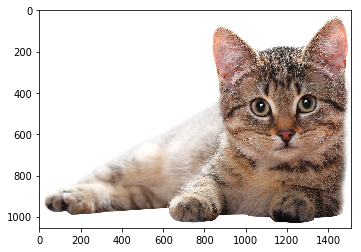

In [24]:
#path = TEST_DATA + '/'

from PIL import Image

#TEST_DATA = '/home/chen2/amaris/data/cat_dog/test/1300.jpg'

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
im = Image.open(TEST_DATA)
array = np.asarray(im)
#print array
#print len(array)
width = INPUT_W
height = INPUT_H
im = im.resize( (width, height), Image.NEAREST )
# print("width ",width, " height ", height)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
pic = os.path.join('/home/chen2/amaris','cat.png')
img=mpimg.imread(pic)
#im = Image.open(pic)
#im.save('4450.png')
#pic = os.path.join('/home/chen2/amaris','4450.png')
#im = Image.open(pic)

imgplot = plt.imshow(img)

#imshow(np.asarray(im))

# #imshow(np.asarray(im))
arr = np.array(im, dtype=np.float32, order='C')
#arr = arr[:,:,::-1]
arr = arr.transpose((2,0,1))
img = arr.ravel()
print("Test Case: ")
print im.format, im.size, im.mode

Test Case: 
PNG (1511, 1054) RGBA


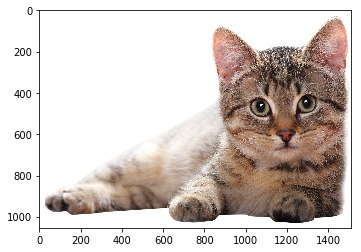

(6370376,)


In [23]:
import pylab as pl
import numpy as np
from PIL import Image

pic = os.path.join('/home/chen2/amaris/data/cat_dog/test','cat.png')

img = Image.open(pic)

img.resize((256,256),Image.NEAREST)
print("Test Case: ")
print img.format, img.size, img.mode

img = np.asarray(img)
pl.imshow(img)
pl.show()

# processing for training
arr = np.array(img, dtype=np.float32, order='C')
arr = arr.transpose((2,0,1))
img = arr.ravel()
print img.shape

In [12]:
parser = parsers.caffeparser.create_caffe_parser()
    #parse mean
mean_blob = parser.parse_binary_proto(IMAGE_MEAN)
parser.destroy()

#Note: In TensorRT C++ no size is reqired, however you need it to cast the array
mean = mean_blob.get_data(INPUT_W * INPUT_H)

data = np.empty([INPUT_H * INPUT_W])
for i in range(INPUT_W * INPUT_H):
    #data[i] = float(img[i])
    data[i] = float(img[i]) - mean[i]
mean_blob.destroy()


In [13]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()
context.set_profiler(G_PROFILER)

In [14]:
assert(engine.get_nb_bindings() == 2)
#convert input data to Float32
img = data.astype(np.float32)
#create output array to receive data
output = np.empty(OUTPUT_SIZE, dtype = np.float32)

In [15]:
d_input = cuda.mem_alloc(1 * img.size * img.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

In [16]:
bindings = [int(d_input), int(d_output)]

In [17]:
#transfer input data to device
cuda.memcpy_htod(d_input, img)
#execute model
#context.enqueue(1, bindings, stream.handle, None)
for i in range(TIMING_INTERATIONS):
    context.execute(1,bindings)
#transfer predictions back
cuda.memcpy_dtoh(output, d_output)
#syncronize threads
#stream.synchronize()

In [18]:
# load labels
labels_file = os.path.join(MODEL_JOB_DIR,'labels.txt')
if not os.path.exists(labels_file):
    print 'Can not fild the lable.txt'
    exit()
    
labels = np.loadtxt(labels_file, str, delimiter='\t')
print np.argmax(output)

print 'output label:', labels[np.argmax(output)], '\naccuracy:', output[np.argmax(output)]
G_PROFILER.print_layer_times()
#print ("Prediction: " + str(np.argmax(output)))
context.destroy()
engine.destroy()
runtime.destroy()

0
output label: cat 
accuracy: 0.8972139
conv1/7x7_s2 + conv1/relu_7x7            0.087ms
pool1/3x3_s2                             0.030ms
pool1/norm1                              0.028ms
conv2/3x3_reduce + conv2/relu_3x3_reduce 0.023ms
conv2/3x3 + conv2/relu_3x3               0.123ms
conv2/norm2                              0.078ms
pool2/3x3_s2                             0.024ms
inception_3a/1x1 + inception_3a/relu_1x1 0.036ms
inception_3a/3x3 + inception_3a/relu_3x3 0.040ms
inception_3a/5x5 + inception_3a/relu_5x5 0.021ms
inception_3a/pool                        0.013ms
inception_3a/pool_proj + inception_3a/re 0.014ms
inception_3a/1x1 copy                    0.005ms
inception_3b/1x1 + inception_3b/relu_1x1 0.050ms
inception_3b/3x3 + inception_3b/relu_3x3 0.071ms
inception_3b/5x5 + inception_3b/relu_5x5 0.052ms
inception_3b/pool                        0.014ms
inception_3b/pool_proj + inception_3b/re 0.023ms
inception_3b/1x1 copy                    0.007ms
pool3/3x3_s2                